In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from scipy.special import kl_div
from tqdm import tqdm

/Users/tristan/miniconda3/envs/deep/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup

In [2]:
def generate_trajectory():
    d_obs = []
    n_obs = []
    a_obs = []

    hist = [0]

    for d in range(1, 5):
        if d == 1:
            amount = 0
        else:
            if sum(hist[-3:]) == 1:
                amount = 0
            else:
                if d == 4:
                    amount = 1
                else:
                    if np.random.rand() < 0.33:
                        amount = 1
                    else:
                        amount = 0

        d_obs.append(d)
        n_obs.append(sum(hist[-3:]))
        a_obs.append(amount)
        hist.append(amount)
    return d_obs, n_obs, a_obs

def generate_dataset(n=10):
    all_d_obs = []
    all_n_obs = []
    all_a_obs = []

    for i in range(n):
        d_obs, n_obs, a_obs = generate_trajectory()
        all_d_obs.append(d_obs)
        all_n_obs.append(n_obs)
        all_a_obs.append(a_obs)

    return pd.DataFrame({
        "D": np.concatenate(all_d_obs),
        "N_3": np.concatenate(all_n_obs),
        "A": np.concatenate(all_a_obs)
    })

def add_trajectory(dataset):
    d_obs, n_obs, a_obs = generate_trajectory()
    sample = pd.DataFrame({
        "D": d_obs,
        "N_3": n_obs,
        "A": a_obs
    })
    return pd.concat((dataset, sample))

### Convergence analysis

In [3]:
all_scores = []

for i in tqdm(range(100)):
    try:
        model = BayesianNetwork([ 
            ('D', 'A'),
            ('N_3', 'A')
        ])
        data = generate_dataset(n=1)

        scores = []
        for i in range(50):    
            cpd_N_3 = MaximumLikelihoodEstimator(model, data).estimate_cpd('N_3')
            cpd_D = MaximumLikelihoodEstimator(model, data).estimate_cpd('D')
            cpd_A = MaximumLikelihoodEstimator(model, data).estimate_cpd('A')
            model.add_cpds(cpd_D, cpd_N_3, cpd_A)

            infer = VariableElimination(model)
            last_proba = infer.query(['D', 'N_3', 'A']).values.flatten()

            data = add_trajectory(data)

            cpd_N_3 = MaximumLikelihoodEstimator(model, data).estimate_cpd('N_3')
            cpd_D = MaximumLikelihoodEstimator(model, data).estimate_cpd('D')
            cpd_A = MaximumLikelihoodEstimator(model, data).estimate_cpd('A')
            model.add_cpds(cpd_D, cpd_N_3, cpd_A)

            infer = VariableElimination(model)
            proba = infer.query(['D', 'N_3', 'A']).values.flatten()

            ave_kl = kl_div(last_proba, proba).mean()
            last_proba = proba

            scores.append(ave_kl)

        scores = np.array(scores)
        scores[np.isinf(scores)] = scores[~np.isinf(scores)].max()
        all_scores.append(scores)
    except:
        pass

all_scores = np.array(all_scores)

100%|██████████| 100/100 [00:21<00:00,  4.61it/s]


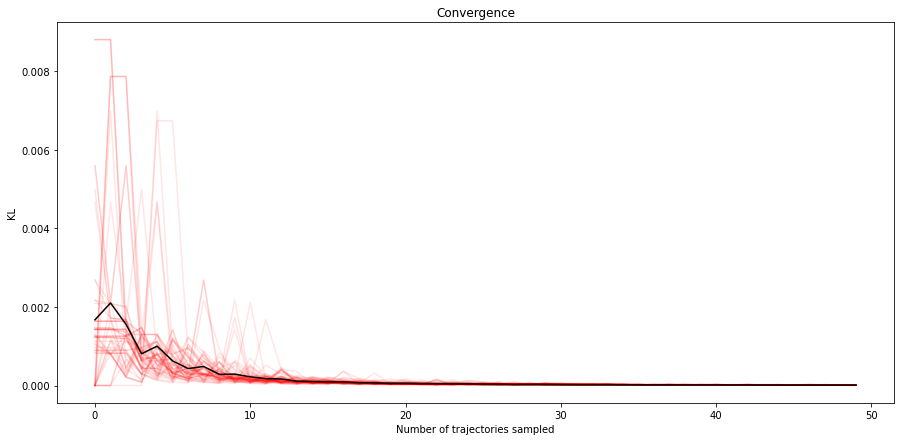

In [4]:
label = True

for scores in all_scores:
    if label:
        plt.plot(range(len(scores)), scores, c='r', alpha=0.1, label='KL')
        label = False
    else:
        plt.plot(range(len(scores)), scores, c='r', alpha=0.1)

plt.plot(range(len(scores)), all_scores.mean(axis=0), c='black', label='Ave KL')
plt.gcf().set_size_inches(15, 7)
plt.title('Convergence')
plt.ylabel('KL')
plt.xlabel('Number of trajectories sampled')
plt.show()

### Sampling rule extraction

In [165]:
model = BayesianNetwork([ 
    ('D', 'A'),
    ('N_3', 'A')
])
data = generate_dataset(n=10000000)
cpd_N_3 = MaximumLikelihoodEstimator(model, data).estimate_cpd('N_3')
cpd_D = MaximumLikelihoodEstimator(model, data).estimate_cpd('D')
cpd_A = MaximumLikelihoodEstimator(model, data).estimate_cpd('A')
model.add_cpds(cpd_D, cpd_N_3, cpd_A)
infer = VariableElimination(model)

In [166]:
print(infer.query(['A'], evidence={"D": 1, "N_3":0}))

+------+----------+
| A    |   phi(A) |
+======+==========+
| A(0) |   1.0000 |
+------+----------+
| A(1) |   0.0000 |
+------+----------+


In [167]:
print(infer.query(['A'], evidence={"D": 2, "N_3":0}))

+------+----------+
| A    |   phi(A) |
+======+==========+
| A(0) |   0.6700 |
+------+----------+
| A(1) |   0.3300 |
+------+----------+


In [168]:
print(infer.query(['A'], evidence={"D": 3, "N_3":0}))

+------+----------+
| A    |   phi(A) |
+======+==========+
| A(0) |   0.6698 |
+------+----------+
| A(1) |   0.3302 |
+------+----------+


In [169]:
print(infer.query(['A'], evidence={"D": 3, "N_3":1}))

+------+----------+
| A    |   phi(A) |
+======+==========+
| A(0) |   1.0000 |
+------+----------+
| A(1) |   0.0000 |
+------+----------+


In [170]:
print(infer.query(['A'], evidence={"D": 4, "N_3":0}))

+------+----------+
| A    |   phi(A) |
+======+==========+
| A(0) |   0.0000 |
+------+----------+
| A(1) |   1.0000 |
+------+----------+


In [171]:
print(infer.query(['A'], evidence={"D": 4, "N_3":1}))

+------+----------+
| A    |   phi(A) |
+======+==========+
| A(0) |   1.0000 |
+------+----------+
| A(1) |   0.0000 |
+------+----------+


### Trajectory analysis

In [183]:
# Unique trajectories (observed)

# Sal day 2
d_obs_1 = np.array([1,2,3,4])
a_obs_1 = np.array([0,1,0,0])
n_3_obs_1 = np.array([0,0,1,1])

# Sal day 3
d_obs_2 = np.array([1,2,3,4])
a_obs_2 = np.array([0,0,1,0])
n_3_obs_2 = np.array([0,0,0,1])

# Sal day 4
d_obs_3 = np.array([1,2,3,4])
a_obs_3 = np.array([0,0,0,1])
n_3_obs_3 = np.array([0,0,0,0])

model = BayesianNetwork([ 
    ('D', 'A'),
    ('N_3', 'A'), 
])

data = pd.DataFrame({
    'D': np.concatenate((d_obs_1, d_obs_2, d_obs_3)),
    'A': np.concatenate((a_obs_1, a_obs_2, a_obs_3)),
    'N_3': np.concatenate((n_3_obs_1, n_3_obs_2, n_3_obs_3))
})

cpd_N_3 = MaximumLikelihoodEstimator(model, data).estimate_cpd('N_3')
cpd_D = MaximumLikelihoodEstimator(model, data).estimate_cpd('D')
cpd_A = MaximumLikelihoodEstimator(model, data).estimate_cpd('A')

model.add_cpds(cpd_D, cpd_N_3, cpd_A)
infer = VariableElimination(model)

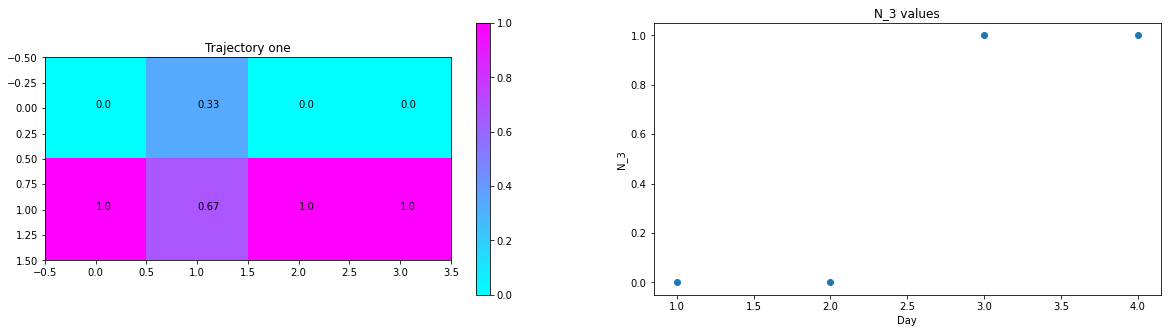

In [191]:
fig, ax = plt.subplots(1, 2)

heights_1 = []

for d, n in zip(d_obs_1, n_3_obs_1):
    heights_1.append(np.flip(infer.query(['A'], evidence={'D': d, 'N_3': n}).values))

heights_1 = np.array(heights_1)

im = ax[0].imshow(heights_1.T, cmap='cool')

for row in range(heights_1.T.shape[0]):
    for col in range(heights_1.T.shape[1]):
        ax[0].text(col, row, round(heights_1.T[row, col], 2), color='black')

ax[0].set_title('Trajectory one')

ax[1].scatter(d_obs_1, n_3_obs_1)
ax[1].set_xlabel('Day')
ax[1].set_ylabel('N_3')
ax[1].set_title('N_3 values')

fig.colorbar(im , ax=ax[0])
fig.set_size_inches(20, 5)
plt.show()

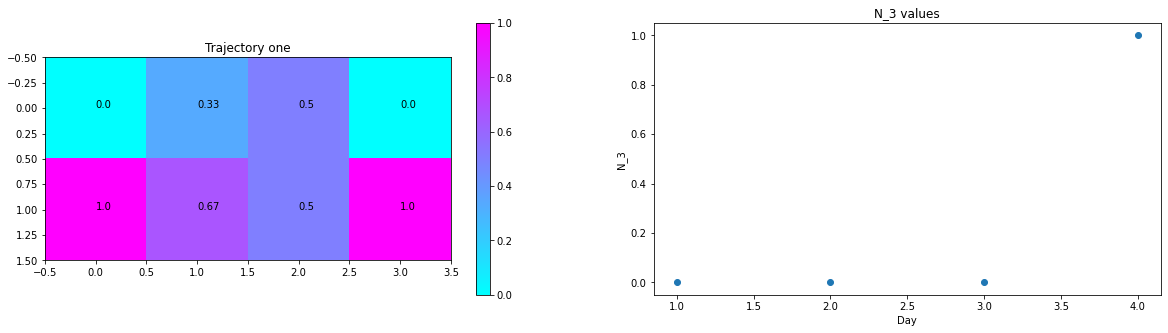

In [192]:
fig, ax = plt.subplots(1, 2)

heights_2 = []

for d, n in zip(d_obs_2, n_3_obs_2):
    heights_2.append(np.flip(infer.query(['A'], evidence={'D': d, 'N_3': n}).values))

heights_2 = np.array(heights_2)

im = ax[0].imshow(heights_2.T, cmap='cool')

for row in range(heights_2.T.shape[0]):
    for col in range(heights_2.T.shape[1]):
        ax[0].text(col, row, round(heights_2.T[row, col], 2), color='black')

ax[0].set_title('Trajectory one')

ax[1].scatter(d_obs_2, n_3_obs_2)
ax[1].set_xlabel('Day')
ax[1].set_ylabel('N_3')
ax[1].set_title('N_3 values')

fig.colorbar(im , ax=ax[0])
fig.set_size_inches(20, 5)
plt.show()

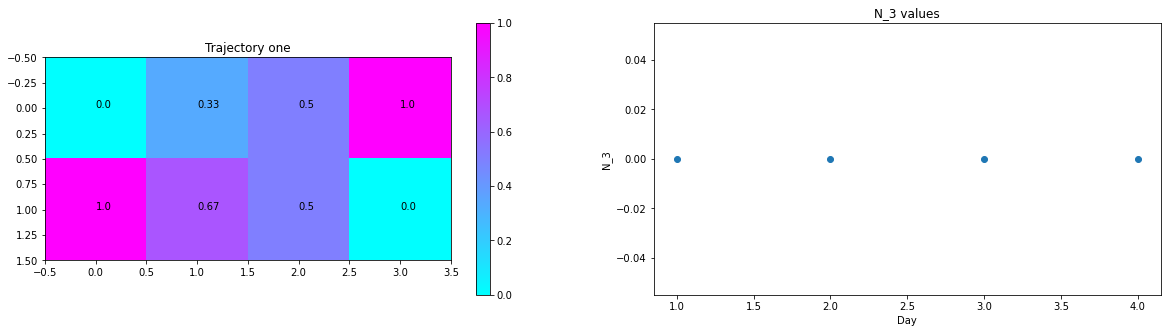

In [193]:
fig, ax = plt.subplots(1, 2)

heights_3 = []

for d, n in zip(d_obs_3, n_3_obs_3):
    heights_3.append(np.flip(infer.query(['A'], evidence={'D': d, 'N_3': n}).values))

heights_3 = np.array(heights_3)

im = ax[0].imshow(heights_3.T, cmap='cool')

for row in range(heights_3.T.shape[0]):
    for col in range(heights_3.T.shape[1]):
        ax[0].text(col, row, round(heights_3.T[row, col], 2), color='black')

ax[0].set_title('Trajectory one')

ax[1].scatter(d_obs_3, n_3_obs_3)
ax[1].set_xlabel('Day')
ax[1].set_ylabel('N_3')
ax[1].set_title('N_3 values')

fig.colorbar(im , ax=ax[0])
fig.set_size_inches(20, 5)
plt.show()

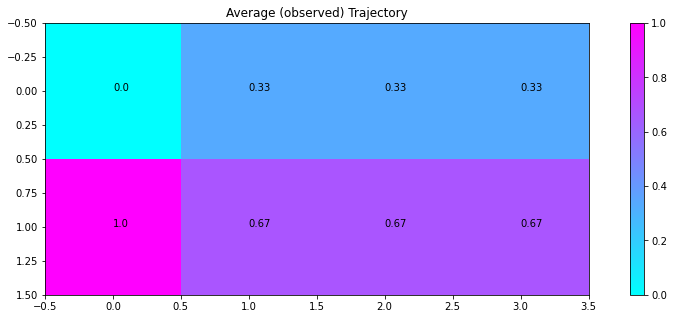

In [195]:
ave_h = (heights_1 + heights_2 + heights_3) / 3

plt.imshow(ave_h.T, cmap='cool')

for row in range(ave_h.T.shape[0]):
    for col in range(ave_h.T.shape[1]):
        plt.text(col, row, round(ave_h.T[row, col], 2), color='black')

plt.colorbar()
plt.title('Average (observed) Trajectory')
plt.gcf().set_size_inches(15, 5)
plt.show()